In [213]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from prophet import Prophet
from matplotlib import dates as mdates
from collections import defaultdict

pd.options.display.max_rows = 500
warnings.filterwarnings('ignore')

In [277]:
import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

In [ ]:
# Read the datasets
data = pd.read_csv("../data/train.csv")
sample_submission = pd.read_csv("../data/sample_submission.csv")

In [222]:
# Concatecate `StateCode` and `StationId` with '-' as separator
data["StateStation"] = data["StateCode"] + "_" + data["StationId"].astype(str)
data["month_year"] = data["Date"].apply(lambda x: dt.datetime.strptime(x, "%Y-%m-%d").strftime("%Y-%m"))

In [223]:
data.head()

,ID_Date,StateCode,StationId,Date,PM2.5,PM10,O3,CO,SO2,AQI,StateStation,month_year
0,AS_4_2021-08-17,AS,4,2021-08-17,51.8364,120.3702,18.0234,0.4896,14.3106,94.0,AS_4,2021-08
1,AS_4_2021-08-18,AS,4,2021-08-18,59.4762,87.0978,34.5270,0.4794,14.7594,124.0,AS_4,2021-08
2,AS_4_2021-08-19,AS,4,2021-08-19,61.0776,79.6008,42.0546,0.5202,16.7484,82.0,AS_4,2021-08
3,AS_4_2021-08-20,AS,4,2021-08-20,56.7222,94.2072,45.7878,0.4998,27.6114,107.0,AS_4,2021-08
4,AS_4_2021-08-21,AS,4,2021-08-21,85.3332,136.7820,44.5638,1.1118,26.4180,107.0,AS_4,2021-08


In [ ]:
# Relevant columns
df = data[['StateStation', 'Date', 'AQI']]
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.columns = ['StateStation', 'ds', 'y']

In [ ]:
# Write a function to split the data into train and validation sorted by ds in ascending order for each StateStation. Validation set contains last 28 days of data.
def split_data(df, state_station, val_days=28):
    df = df[df['StateStation'] == state_station].sort_values(by='ds', ascending=True)
    train = df[:-val_days]
    val = df[-val_days:]
    return train, val

In [ ]:
# Write a function to predict 'y' using Prophet for `StateStation` = 'AS-4'
def predict_state_station(df):
    # Filter the dataframe for `StateStation` = 'AS-4'
    # df = df[df['StateStation'] == state_station].sort_values(by='ds', ascending=True)
    # Instantiate the model
    model = Prophet()
    # Fit the model
    model.fit(df)
    # Create a dataframe with future dates
    future = model.make_future_dataframe(periods=28)
    # Predict the future values
    forecast = model.predict(future)
    # Return the predicted values
    return forecast

In [ ]:
# Write a function to calculate the Modified Mean Absolute Error (MMAE) - it will penalize the under-predictions more heavily than over-predictions with a ratio of 1.5:1.
def mmae(y_true, y_pred):
    # Convert y_true and y_pred to numpy arrays
    y_true = np.array(y_true.y)
    y_pred = np.array(y_pred.yhat)
    return np.mean(np.abs(y_true - y_pred) * np.where(y_true > y_pred, 1.5, 1))

## Predict all 28 days

In [ ]:
def training(df, val_days=28):
    # Create a dictionary to store the predictions
    predictions = dict()
    # Create a dictionary to store the actual values
    actuals = dict()
    # Create a dictionary to store the MMAE scores
    scores = dict()
    # Loop over each StateStation
    for state_station in df['StateStation'].unique():
        # Split the data into train and validation
        train, val = split_data(df, state_station, val_days)
        # Predict the values for the validation set
        forecast = predict_state_station(train)
        # Calculate the MMAE score
        score = mmae(val, forecast[-val_days:])
        # Save a dataframe of the predictions, scores, and actual values to the respective dictionaries with forecasted dates
        predictions[state_station] = forecast[-val_days:][['ds', 'yhat']]
        actuals[state_station] = val[['ds', 'y']]
        scores[state_station] = score
    return actuals, predictions, scores

In [ ]:
# Create a final_traininig function to train the model on the entire dataset and predict the values for the next 28 days. Store the results in `predictions`.
def final_training(df, val_days=28):
    # Create a dictionary to store the predictions
    predictions = dict()
    # Loop over each StateStation
    for state_station in df['StateStation'].unique():
        # Split the data into train and validation
        train = df[df['StateStation'] == state_station].sort_values(by='ds', ascending=True)
        # Predict the values for the validation set
        forecast = predict_state_station(train)
        # Save a dataframe of the predictions values to the dictionaries with forecasted dates
        predictions[state_station] = forecast[-val_days:][['ds', 'yhat']]
    return predictions

In [ ]:
# plot predicted values with actual values
def plot_predictions(actual, prediction, state_station):
    # Convert the actuals and predictions to numpy arrays
    actuals = np.array(actual.y)
    predictions = np.array(prediction.yhat)
    # Create a dataframe with actuals and predictions
    df = pd.DataFrame({'actuals': actuals, 'predictions': predictions}, index=actual.ds.values)
    # Plot the actuals and predictions
    fig = plt.figure(figsize=(12, 6))
    plt.plot(df['actuals'], label='Actuals')
    plt.plot(df['predictions'], label='Predictions')
    plt.xticks(df.index.values, rotation=90)
    plt.legend()
    # df.plot(figsize=(12, 6))
    plt.title(f"Predictions vs Actuals for {state_station}")
    plt.show()

In [140]:
# Train the model on the train and val dataset
actuals, predictions, scores = training(df)

In [141]:
# Average MMAE score
np.mean([score for score in scores.values()])

51.250498323301784

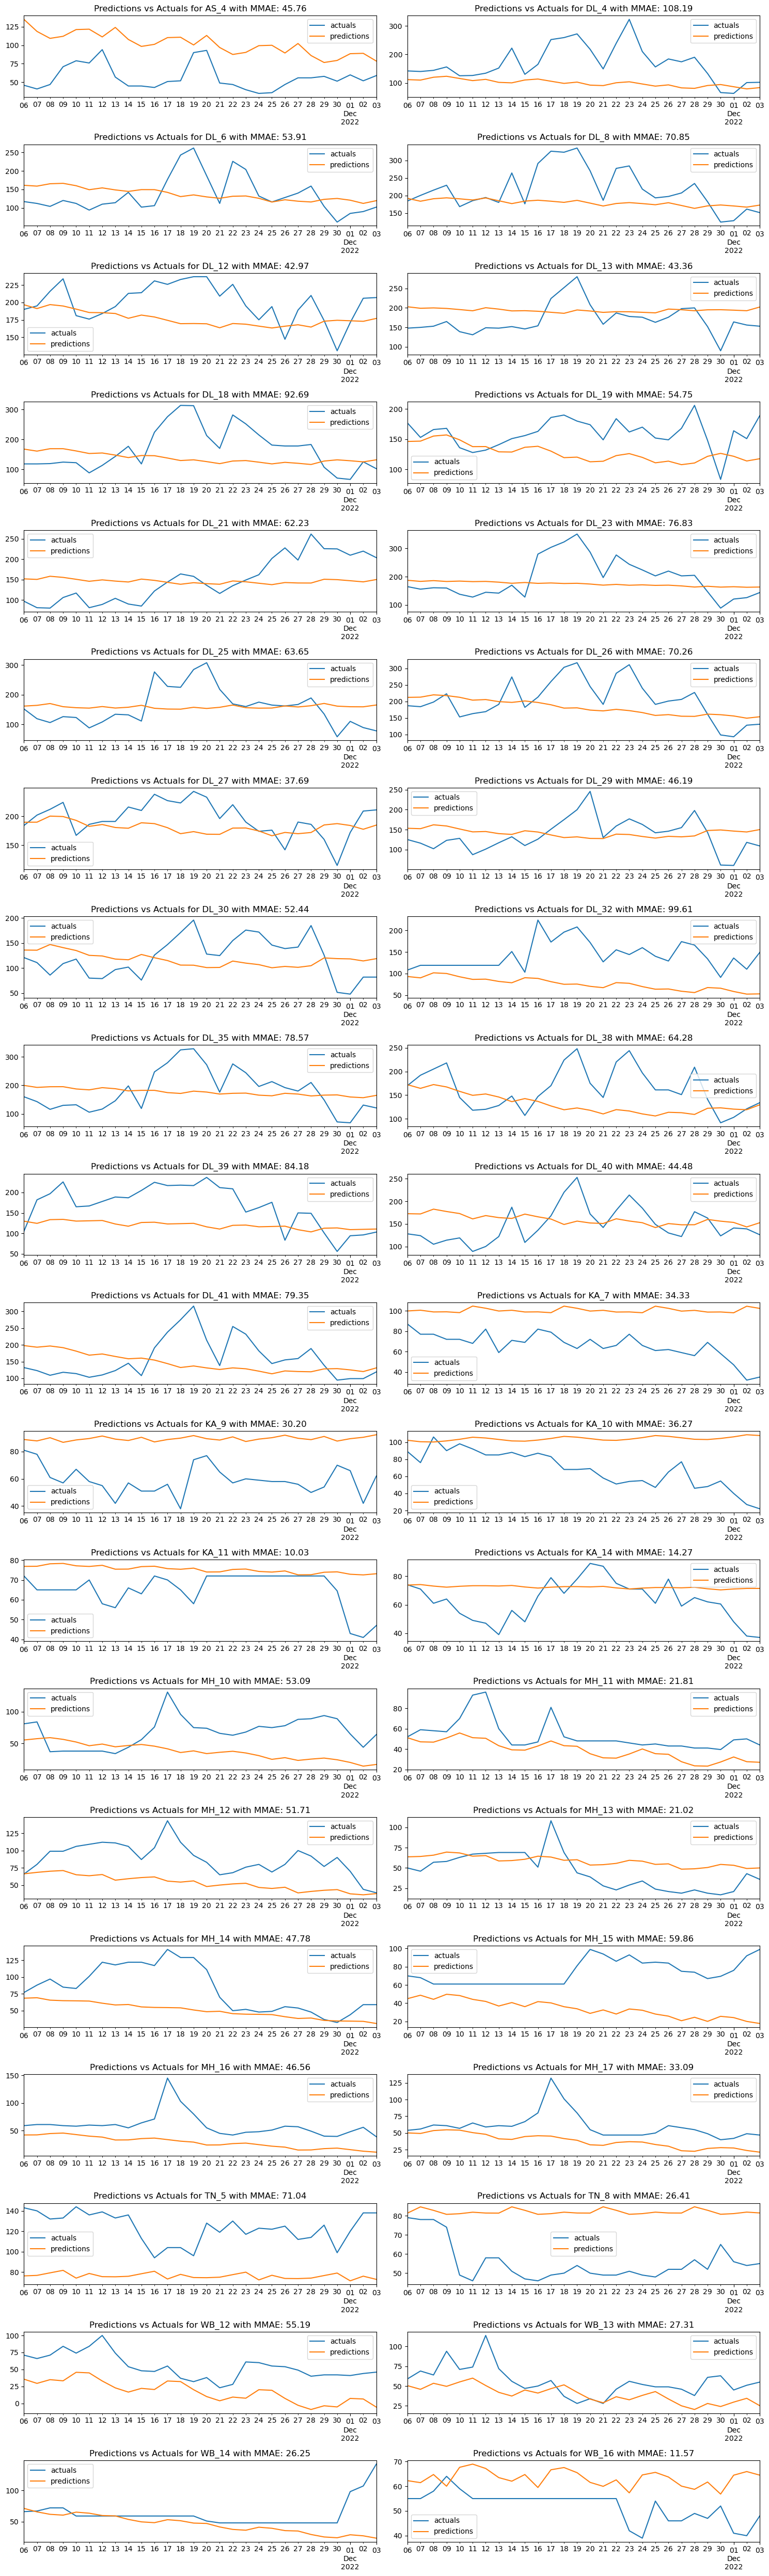

In [ ]:
plot_predictions(actuals, predictions, scores)

In [ ]:
# # For each StateStation, plot the actuals and predictions
# for state_station in df['StateStation'].unique():
#     plot_predictions(actuals[state_station], predictions[state_station], state_station)

In [ ]:
final_predictions = final_training(df)

In [ ]:
# Create a dataframe with the predictions. Column as state_station + ds as one column and yhat as another column
output = pd.DataFrame()
for state_station in predictions.keys():
    tmp = final_predictions[state_station]
    tmp['StateStation_ds'] = state_station + '_' + tmp['ds'].astype(str)
    tmp = tmp[['StateStation_ds', 'yhat']]
    output = pd.concat([output, tmp])
output.columns = ['ID_Date', 'AQI']
output.reset_index(drop=True, inplace=True)

In [ ]:
output.head()

,ID_Date,AQI
0,AS_4_2022-12-04,52.056396
1,AS_4_2022-12-05,35.190210
2,AS_4_2022-12-06,26.514976
3,AS_4_2022-12-07,28.870790
4,AS_4_2022-12-08,37.157670


In [ ]:
output.to_csv('./submissions/submission.csv', index=False)

## Cross validation and Tune Parameters

In [166]:
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric

In [341]:
df = data[['StateStation', 'month_year', 'Date', 'AQI']]
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.columns = ['StateStation', 'month_year', 'ds', 'y']
df.y = np.log(df.y)

In [342]:
df.head()

,StateStation,month_year,ds,y
0,AS_4,2021-08,2021-08-17,4.543295
1,AS_4,2021-08,2021-08-18,4.820282
2,AS_4,2021-08,2021-08-19,4.406719
3,AS_4,2021-08,2021-08-20,4.672829
4,AS_4,2021-08,2021-08-21,4.672829


In [343]:
state_station = 'DL_12'
train = df[df['StateStation'] == state_station].sort_values(by='ds', ascending=True).reset_index(drop=True)

In [344]:
train.head()

,StateStation,month_year,ds,y
0,DL_12,2020-08,2020-08-02,5.739793
1,DL_12,2020-08,2020-08-03,5.545177
2,DL_12,2020-08,2020-08-04,5.476464
3,DL_12,2020-08,2020-08-05,5.575949
4,DL_12,2020-08,2020-08-06,5.723585


In [345]:
train.columns

Index(['StateStation', 'month_year', 'ds', 'y'], dtype='object')

<Axes: >

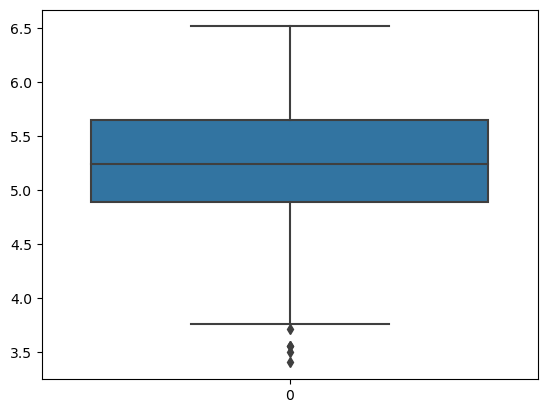

In [346]:
sns.boxplot(train['y'])

In [259]:
t = train[train.y > 500]
t

,StateStation,month_year,ds,y
97,AS_4,2021-11,2021-11-26,855.0
175,AS_4,2022-02,2022-02-13,975.0


In [260]:
train.y = train.apply(lambda x: df.groupby('month_year').y.mean().loc[x.month_year] if x.y > 400 else x.y, axis=1)

In [261]:
train.y.max()

385.0

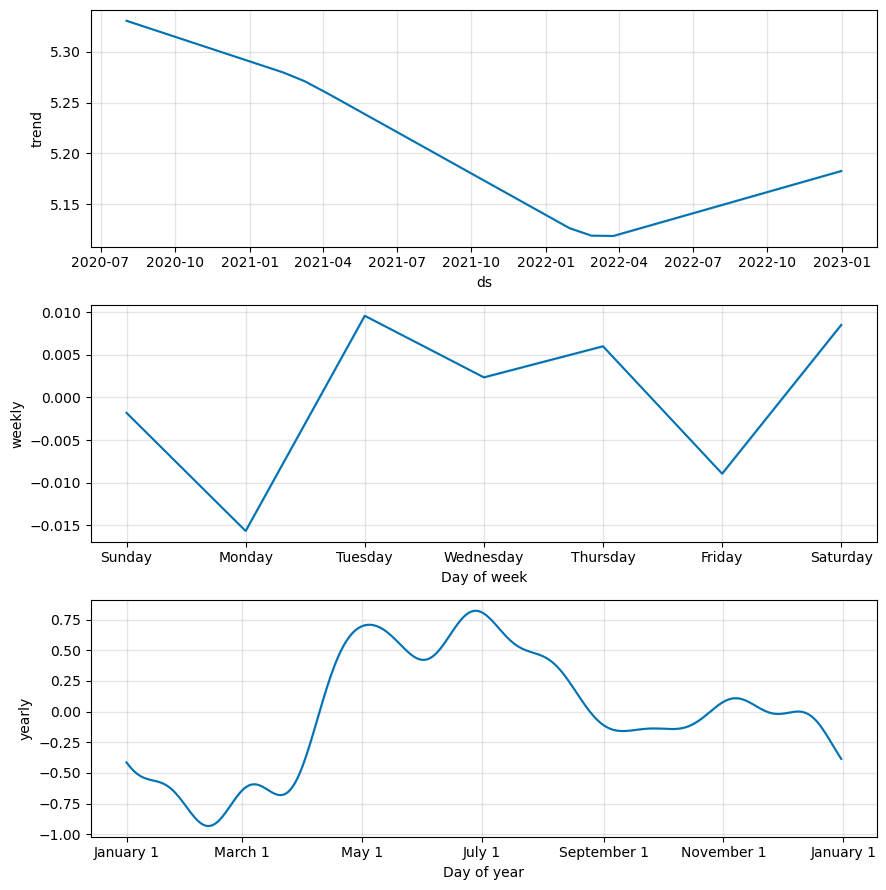

In [347]:
model = Prophet()
model.fit(train)
future = model.make_future_dataframe(periods=28)
# Predict the future values
forecast = model.predict(future)
model.plot_components(forecast)
plt.show()

In [348]:
initial_days = train.shape[0] - 28
model = Prophet()
model.fit(train)
df_cv = cross_validation(model, initial=f'{initial_days} days', period='1 days', horizon = '9 days')

  0%|          | 0/36 [00:00<?, ?it/s]

In [350]:
df_cv.y = np.exp(df_cv.y)
df_cv.yhat = np.exp(df_cv.yhat)

In [351]:
mmae(df_cv[-28:], df_cv[-28:])

28.895120146894264

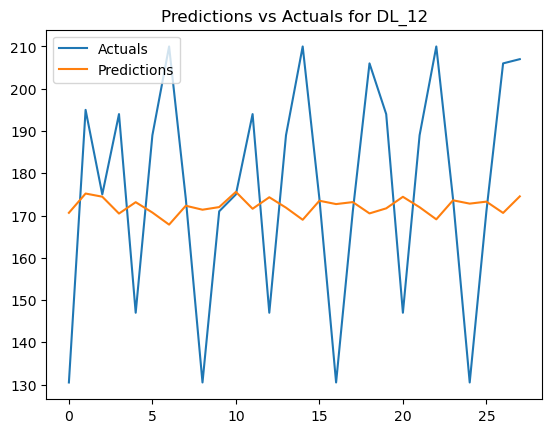

In [352]:
t1 = df_cv[-28:].reset_index(drop=True)
t2 = predictions['AS_4'].reset_index(drop=True)
plt.plot(t1['y'], label='Actuals')
plt.plot(t1['yhat'], label='Predictions')
# plt.plot(t2['yhat'], label='Predictions-Before')
# plt.xticks(df_cv['ds'][-28:].values, rotation=90)
plt.legend()
plt.title(f"Predictions vs Actuals for {state_station}")
plt.show()
# df_cv[-28:][['y', 'yhat']].plot()
# 

In [353]:
df_p = performance_metrics(df_cv)

In [354]:
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,1 days,1092.396316,33.051419,26.869177,0.139564,0.114954,0.143295,0.0
1,2 days,1153.764308,33.967106,27.553821,0.143284,0.115918,0.147125,0.0
2,3 days,1197.794396,34.609166,28.002359,0.145140,0.124494,0.149631,0.0
3,4 days,1263.015321,35.538927,28.776812,0.147643,0.126227,0.153345,0.0
4,5 days,1282.053567,35.805776,28.606183,0.146584,0.131915,0.152497,0.0
5,6 days,1358.817274,36.862139,30.153418,0.157582,0.140490,0.162500,0.0
6,7 days,1315.212624,36.265860,29.264881,0.149699,0.145466,0.156528,0.0
7,8 days,1348.299541,36.719199,29.834777,0.150348,0.137142,0.158908,0.0
8,9 days,1399.094050,37.404466,30.545649,0.153091,0.156830,0.162469,0.0


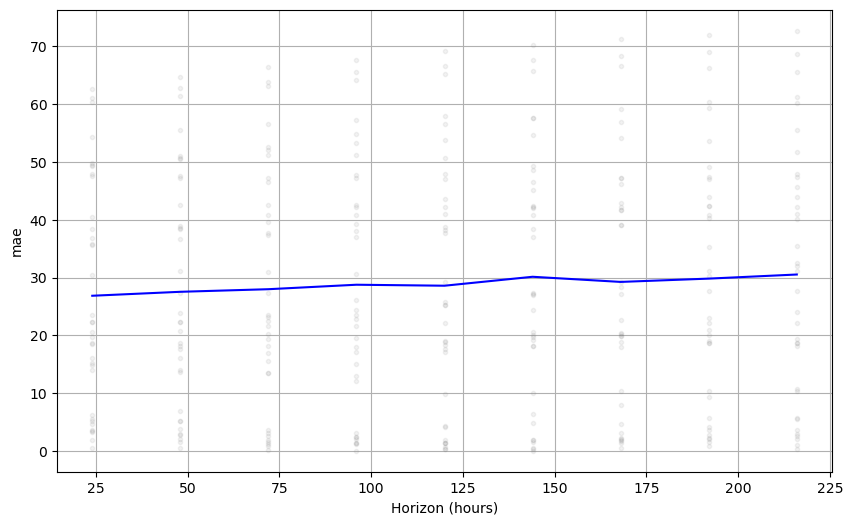

In [355]:
plot_cross_validation_metric(df_cv, metric='mae')
plt.show()

In [358]:
# model.plot(df_cv[-28:][['ds', 'y', 'yhat', 'yhat_lower', 'yhat_upper']])
# plt.show()

In [359]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

In [360]:
import itertools

In [361]:
# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mae = []  # Store the RMSEs for each params here

In [362]:
# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train)  # Fit model with given params
    df_cv = cross_validation(model, initial=f'{initial_days} days', period='1 days', horizon = '9 days')
    df_cv.y = np.exp(df_cv.y)
    df_cv.yhat = np.exp(df_cv.yhat)
    df_p = performance_metrics(df_cv, rolling_window=1)
    mae.append(df_p['mae'].values[0])

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

In [363]:
# Find the best parameters - DL_12
tuning_results = pd.DataFrame(all_params)
tuning_results['mae'] = mae
print(tuning_results)

    changepoint_prior_scale  seasonality_prior_scale        mae
0                     0.001                     0.01  28.845231
1                     0.001                     0.10  28.845231
2                     0.001                     1.00  28.845231
3                     0.001                    10.00  28.845231
4                     0.010                     0.01  28.845231
5                     0.010                     0.10  28.845231
6                     0.010                     1.00  28.845231
7                     0.010                    10.00  28.845231
8                     0.100                     0.01  28.845231
9                     0.100                     0.10  28.845231
10                    0.100                     1.00  28.845231
11                    0.100                    10.00  28.845231
12                    0.500                     0.01  28.845231
13                    0.500                     0.10  28.845231
14                    0.500             

In [293]:
# Find the best parameters - AS_$
tuning_results = pd.DataFrame(all_params)
tuning_results['mae'] = mae
print(tuning_results)

    changepoint_prior_scale  seasonality_prior_scale       mae
0                     0.001                     0.01  47.89916
1                     0.001                     0.10  47.89916
2                     0.001                     1.00  47.89916
3                     0.001                    10.00  47.89916
4                     0.010                     0.01  47.89916
5                     0.010                     0.10  47.89916
6                     0.010                     1.00  47.89916
7                     0.010                    10.00  47.89916
8                     0.100                     0.01  47.89916
9                     0.100                     0.10  47.89916
10                    0.100                     1.00  47.89916
11                    0.100                    10.00  47.89916
12                    0.500                     0.01  47.89916
13                    0.500                     0.10  47.89916
14                    0.500                     1.00  4

In [302]:
initial_days = train.shape[0]
model = Prophet()
model.fit(train)
df_cv = cross_validation(model, initial=f'{initial_days} days', period='2 days', horizon = '2 days')

  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
train, val = split_data(df, 'AS-4')
forecast = predict_state_station(train, 'AS-4')

18:32:57 - cmdstanpy - INFO - Chain [1] start processing
18:32:57 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
val.shape

(28, 3)

In [ ]:
mmae(val['y'], forecast['yhat'][-28:])

45.76297912755496

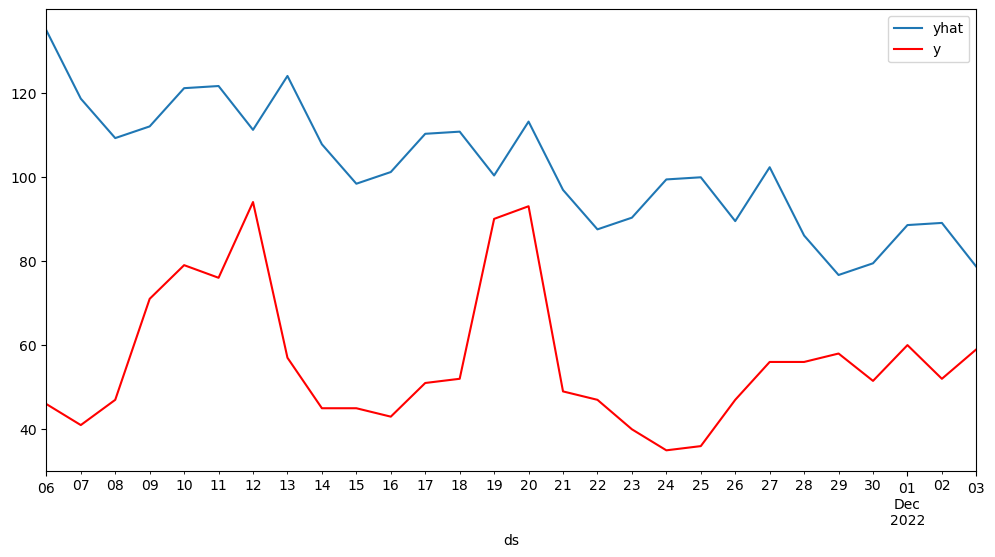

In [ ]:
# Plot the predicted values
forecast[-28:].plot(x='ds', y='yhat', figsize=(12, 6))
plt.plot(val['ds'], val['y'], 'r', label="y")
plt.legend()
plt.show()

In [ ]:
# # Write a function to get the predictions for each StateStation
# def get_predictions(df, state_station):
#     df = df[df['StateStation'] == state_station]
#     df = df[['ds', 'y']]
#     df = df.set_index('ds')
#     df = df.resample('D').mean()
#     df = df.reset_index()
#     df = df.dropna()
#     df = df.reset_index(drop=True)
#     df.columns = ['ds', 'y']
#     m = Prophet()
#     m.fit(df)
#     future = m.make_future_dataframe(periods=30)
#     forecast = m.predict(future)
#     forecast = forecast[['ds', 'yhat']]
#     forecast.columns = ['Date', 'AQI']
#     forecast['Date'] = forecast['Date'].dt.strftime('%Y-%m-%d')
#     return forecast